In [73]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('prac').getOrCreate()

In [74]:
from functools import reduce

u_item = spark.read.csv('u.item',sep='|',inferSchema=True)

u_item_old_columns = u_item.columns
u_item_new_columns =  ['item-id','movie-title','release-date','video-release-data','IMDB-url','unknown','action','adventure','animation',"children's",'comedy','crime','documentary','drama','fantasy','film-noir','horror','musical','mystery','romance','sci-fi','thriller','war','western']

u_item = reduce(lambda df,ids: df.withColumnRenamed(u_item_old_columns[ids],u_item_new_columns[ids]),range(len(u_item_old_columns)),u_item)

u_item = u_item.drop(*['release-date','video-release-data','IMDB-url'])

u_item.printSchema()

root
 |-- item-id: integer (nullable = true)
 |-- movie-title: string (nullable = true)
 |-- unknown: integer (nullable = true)
 |-- action: integer (nullable = true)
 |-- adventure: integer (nullable = true)
 |-- animation: integer (nullable = true)
 |-- children's: integer (nullable = true)
 |-- comedy: integer (nullable = true)
 |-- crime: integer (nullable = true)
 |-- documentary: integer (nullable = true)
 |-- drama: integer (nullable = true)
 |-- fantasy: integer (nullable = true)
 |-- film-noir: integer (nullable = true)
 |-- horror: integer (nullable = true)
 |-- musical: integer (nullable = true)
 |-- mystery: integer (nullable = true)
 |-- romance: integer (nullable = true)
 |-- sci-fi: integer (nullable = true)
 |-- thriller: integer (nullable = true)
 |-- war: integer (nullable = true)
 |-- western: integer (nullable = true)



In [75]:
u_data = spark.read.csv('u.data',sep='\t',inferSchema=True)

u_data_old_columns = u_data.columns
u_data_new_columns = ['user-id','item-id','rating','timestamp']

u_data = reduce(lambda df,ids: df.withColumnRenamed(u_data_old_columns[ids],u_data_new_columns[ids]),range(len(u_data_new_columns)),u_data)

u_data = u_data.drop('timestamp')

u_data.show()
u_data.count()

+-------+-------+------+
|user-id|item-id|rating|
+-------+-------+------+
|    196|    242|     3|
|    186|    302|     3|
|     22|    377|     1|
|    244|     51|     2|
|    166|    346|     1|
|    298|    474|     4|
|    115|    265|     2|
|    253|    465|     5|
|    305|    451|     3|
|      6|     86|     3|
|     62|    257|     2|
|    286|   1014|     5|
|    200|    222|     5|
|    210|     40|     3|
|    224|     29|     3|
|    303|    785|     3|
|    122|    387|     5|
|    194|    274|     2|
|    291|   1042|     4|
|    234|   1184|     2|
+-------+-------+------+
only showing top 20 rows



100000

In [76]:
item_rating_join = u_item.join(u_data,on='item-id').drop('user-id')

item_rating_join.show()

+-------+--------------------+-------+------+---------+---------+----------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+---+-------+------+
|item-id|         movie-title|unknown|action|adventure|animation|children's|comedy|crime|documentary|drama|fantasy|film-noir|horror|musical|mystery|romance|sci-fi|thriller|war|western|rating|
+-------+--------------------+-------+------+---------+---------+----------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+---+-------+------+
|    242|        Kolya (1996)|      0|     0|        0|        0|         0|     1|    0|          0|    0|      0|        0|     0|      0|      0|      0|     0|       0|  0|      0|     3|
|    302|L.A. Confidential...|      0|     0|        0|        0|         0|     0|    1|          0|    0|      0|        1|     0|      0|      1|      0|     0|       1|  0|      0|     3|
|    377| Heavyweights (1994)|      0|  

In [77]:
item_rating_join=item_rating_join.withColumnRenamed("children's","children")

In [78]:
from pyspark.ml.feature import VectorAssembler

assemble = VectorAssembler(
    inputCols=['unknown','action','adventure','animation',"children",'comedy','crime','documentary','drama','fantasy','film-noir','horror','musical','mystery','romance','sci-fi','thriller','war','western','rating'],
    outputCol='new_feature'    
    )

assembled_data = assemble.transform(item_rating_join)

assembled_data.show()


+-------+--------------------+-------+------+---------+---------+--------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+---+-------+------+--------------------+
|item-id|         movie-title|unknown|action|adventure|animation|children|comedy|crime|documentary|drama|fantasy|film-noir|horror|musical|mystery|romance|sci-fi|thriller|war|western|rating|         new_feature|
+-------+--------------------+-------+------+---------+---------+--------+------+-----+-----------+-----+-------+---------+------+-------+-------+-------+------+--------+---+-------+------+--------------------+
|    242|        Kolya (1996)|      0|     0|        0|        0|       0|     1|    0|          0|    0|      0|        0|     0|      0|      0|      0|     0|       0|  0|      0|     3|(20,[5,19],[1.0,3...|
|    302|L.A. Confidential...|      0|     0|        0|        0|       0|     0|    1|          0|    0|      0|        1|     0|      0|      1|      0|  

In [87]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

scores = []
evaluator = ClusteringEvaluator(featuresCol='new_feature',metricName='silhouette',distanceMeasure='squaredEuclidean')

for K in range(2,11):

    KMeans_=KMeans(featuresCol='new_feature', k=K)

    KMeans_fit=KMeans_.fit(assembled_data)

    KMeans_transform=KMeans_fit.transform(assembled_data) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    scores.append(evaluation_score)

Text(0, 0.5, 'Silhouette Score')

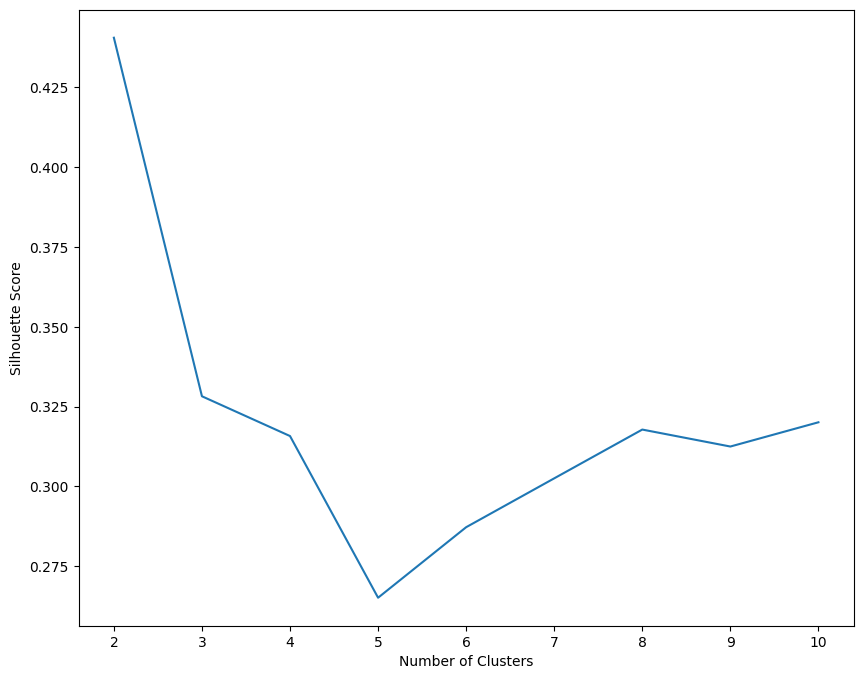

In [88]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

In [89]:
KMeans_=KMeans(featuresCol='new_feature', k=3) 
KMeans_Model=KMeans_.fit(assembled_data)
KMeans_Assignments=KMeans_Model.transform(assembled_data)

In [90]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="new_feature", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)

In [91]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [92]:
cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

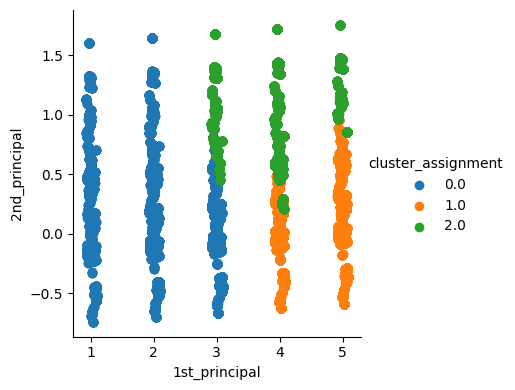

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=4).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()